### Pinhole Camera model for NeRF
other camera models can also be used but the easiest and the most used one is the pinhole model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch

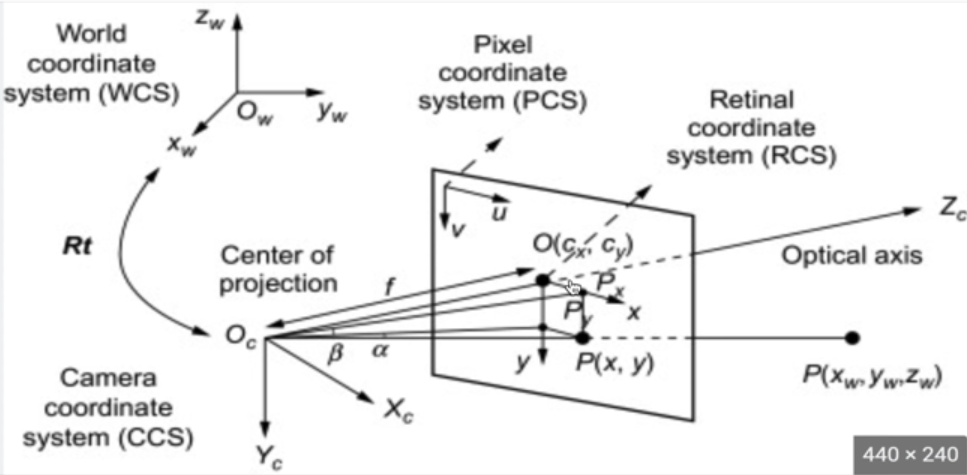

In [2]:
H = 400
W = 400
f = 1200

In [3]:
rays_origin = np.zeros((H*W, 3)) #3 coz 3d
rays_direction = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)

#creating a coordinate grid
u, v = np.meshgrid(u, v)
print(f"u grid values: \n{u}\n")
print(f"v grid values: \n{v}")
rays_direction.shape

u grid values: 
[[  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 ...
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]
 [  0   1   2 ... 397 398 399]]

v grid values: 
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [397 397 397 ... 397 397 397]
 [398 398 398 ... 398 398 398]
 [399 399 399 ... 399 399 399]]


(160000, 3)

### direction of vec from grid to origin

In [4]:
x = u - (W/2)  # we want origin to have direction (0, 0, z) not (200, 200, z)
y = v - (H/2)
z = np.ones_like(u) * f

x.shape, y.shape, z.shape

((400, 400), (400, 400), (400, 400))

In [5]:
dirs = np.stack((x,
                 -y, # negative since we want y axis downwards(refer to the image above)
                 -z), axis=-1) # z faces us, therfore -z from origin to plane

dirs.shape

(400, 400, 3)

In [6]:
dirs[0]

array([[ -200.,   200., -1200.],
       [ -199.,   200., -1200.],
       [ -198.,   200., -1200.],
       ...,
       [  197.,   200., -1200.],
       [  198.,   200., -1200.],
       [  199.,   200., -1200.]])

-200.,   200., -1200.

-400.,   400., -2400.

both are the same therefor normalize

In [7]:
#origin at 
dirs[200,200]

array([    0.,    -0., -1200.])

### normalizing the rays

In [8]:
rays_direction = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) #normalize along the 3rd dimensioni
rays_direction[0], rays_direction.shape

(array([[-0.16222142,  0.16222142, -0.97332853],
        [-0.1614315 ,  0.16224272, -0.9734563 ],
        [-0.16064128,  0.16226391, -0.97358349],
        ...,
        [ 0.15985074,  0.16228501, -0.97371008],
        [ 0.16064128,  0.16226391, -0.97358349],
        [ 0.1614315 ,  0.16224272, -0.9734563 ]]),
 (400, 400, 3))

In [9]:
#normalized origin now at 
rays_direction[200,200]

array([ 0., -0., -1.])

In [10]:
def plot_rays(o, d, t):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::50], pt2[::50]): #plot 1/50
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    
    plt.xlabel('$X$ - coord')
    plt.ylabel('$Y$ - coord')
    
    plt.show()

In [11]:
rays_direction.reshape(-1, 3).shape, rays_direction.shape

((160000, 3), (400, 400, 3))

In [12]:
#in this convention
rays_direction = rays_direction.reshape(-1, 3)
rays_direction.shape, rays_origin.shape

((160000, 3), (160000, 3))

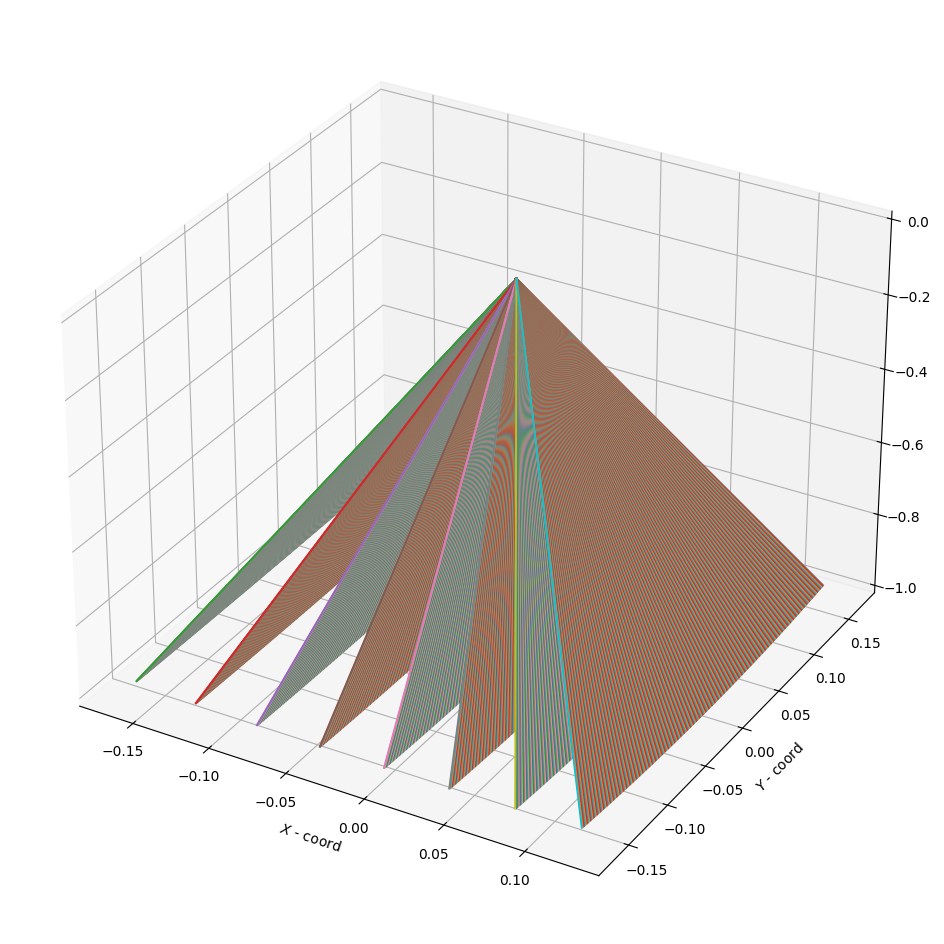

In [13]:
plot_rays(rays_origin, rays_direction, 1)

## Ray tracing and assign colors to the rays to create an image

The equation of a sphere in three-dimensional Cartesian coordinates is given by:

$$
(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 = r^2
$$

where $ (x_0, y_0, z_0) $ represents the center of the sphere and $ r $ is the radius.




 where $ x, y, z $ are the coordinates of the point where the ray $ r(t) $ intersects the sphere, with equation
\begin{align*}
x & = o_x + t \cdot d_x \\
y & = o_y + t \cdot d_y \\
z & = o_z + t \cdot d_z
\end{align*}

Introducing Eq. 2 in Eq. 1 yields
\begin{equation}
(o_x + t \cdot d_x - x_c)^2 + (o_y + t \cdot d_y - y_c)^2 + (o_z + t \cdot d_z - z_c)^2 = r^2.
\end{equation}

We want to find $ t $ that solves Eq. 3. This is a second order equation in $ t $, that can be rewritten as
\begin{equation}
at^2 + bt + c = 0
\end{equation}
with
\begin{align*}
a & = d_x^2 + d_y^2 + d_z^2 \\
b & = 2 \cdot ((d_x \cdot (o_x - x_c)) + (d_y \cdot (o_y - y_c)) + (d_z \cdot (o_z - z_c))) \\
c & = (o_x - x_c)^2 + (o_y - y_c)^2 + (o_z - z_c)^2 - r^2
\end{align*}


#### at position X(color, density)
- if density = 0, then no color
- if denisty > 0 then assign color ie inside the sphere

In [29]:
class Sphere():
    def __init__(self, position, radius, color):
        self.position = position
        self.radius = radius
        self.color = color
        
    def intersect(self, x): #tells if ray hits the sphere or not
        """_summary_

        Args:
            x (parameter): points shape [batch_size, 3]

        Returns:
            _type_: _description_
        """
        # check if inside the sphere
        # (x-xo)^2 + (y-yo)^2 + (z-zo)^2 < r^2
        condition =(x[:, 0] - self.position[0])**2 + (x[:, 1] - self.position[1])**2 + (x[:, 2] - self.position[2])**2 <= self.radius**2
        
        print(condition.shape)
        number_of_rays = x.shape[0]
        colors = torch.zeros((number_of_rays, 3))
        density = torch.zeros((number_of_rays, 1))
        
        print(colors[condition].shape)
        print(self.color.shape)
        colors[condition] = self.color #assign color where condition passes
        density[condition] = 10 # assume constant
        
        return colors, density

In [35]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)
    accumulated_transmittance[:, 1:] = accumulated_transmittance[:, :-1] #since we shift to the right
    #sum goes from i =1 to i= N-1
    accumulated_transmittance[:, 0] = 1.  # as T0 should be 1
    #will improve to better differeniability later!
    return accumulated_transmittance

Lets say we need $T_4$

$T_4$ = exp(-delta1 * sigma1) * exp(-delta2 * sigma2) * exp(-delta3 * sigma3)

Therefore we take cumulative product

In [45]:
def rendering(model, rays_origin, rays_direction, tn, tf, nb_bins = 100, device = 'cpu'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    t = torch.linspace(tn, tf, nb_bins).to(device) #making the bins #size is no of bins
    print(t)
    print(t.shape)
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10]))) #size is no of bins - 1 so we concat infinity as the last value
    #most nerf papers take the last delta value as infinity
    
    #convert to torch.Tensors
    rays_origin = torch.from_numpy(rays_origin)
    rays_direction = torch.from_numpy(rays_direction)
    # x = rays_origin + t * rays_direction
    # t.shape = [nb_bins]
    # rays_origin.shape and rays_direction = [nb_rays, nb_bins, 3]
    
    #broadcasting does not work in here therfore reshape the vectors
    
    # t.shape = [1, nb_bins, 1]
    # rays_origin.shape and rays_direction = [nb_rays, 1, 3]
    
    x = rays_origin.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_direction.unsqueeze(1)
    print(f"x's shape: (number of rays, number of bins, colors) = ", x.shape)
    # query the opacity and the colors at each point x
    #query the color and the denisty at each point X to
    # comput the integral
    
    colors, density = model.intersect(x.reshape(-1, 3))
    
    #reshape colors to [nb_rays, nb_bins, 3]
    #reshape density to [nb_rays, nb_bins, 1]
    colors = colors.reshape((x.shape[0], nb_bins, 3)) #shape [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins, 1))
    
    alpha = 1 - torch.exp(-density.squeeze() * delta.unsqueeze(0)) # shape [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # shape [nb_rays, nb_bins, 1]
    print("T shape: ",T.shape)
    print("Alpha shape: ",alpha.shape)
    print("Colors shape: ",colors.shape)
    color = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) #shape [nb_rays, 3]
    print(f"return color shape: {color.shape}")
    return color

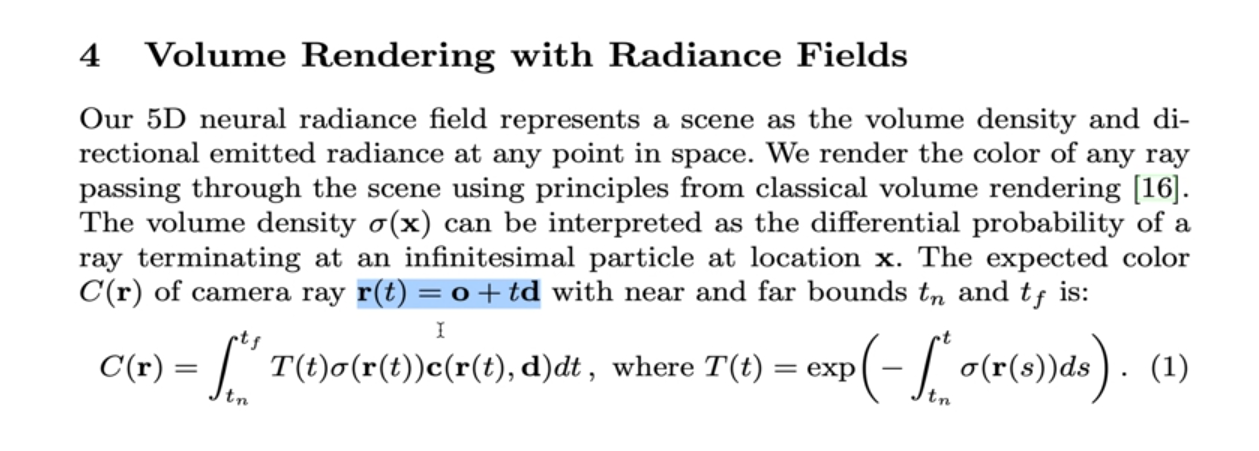

In [46]:
trial_origin = torch.Tensor([0., 0., -1.])
trial_color = torch.Tensor([1., 0., 1.])
trial_radius = torch.Tensor([.1])

s = Sphere(trial_origin, trial_radius,trial_color)
px_colors = rendering(s, rays_origin,rays_direction, 0.8, 1.2)

tensor([0.8000, 0.8040, 0.8081, 0.8121, 0.8162, 0.8202, 0.8242, 0.8283, 0.8323,
        0.8364, 0.8404, 0.8444, 0.8485, 0.8525, 0.8566, 0.8606, 0.8646, 0.8687,
        0.8727, 0.8768, 0.8808, 0.8848, 0.8889, 0.8929, 0.8970, 0.9010, 0.9051,
        0.9091, 0.9131, 0.9172, 0.9212, 0.9253, 0.9293, 0.9333, 0.9374, 0.9414,
        0.9455, 0.9495, 0.9535, 0.9576, 0.9616, 0.9657, 0.9697, 0.9737, 0.9778,
        0.9818, 0.9859, 0.9899, 0.9939, 0.9980, 1.0020, 1.0061, 1.0101, 1.0141,
        1.0182, 1.0222, 1.0263, 1.0303, 1.0343, 1.0384, 1.0424, 1.0465, 1.0505,
        1.0545, 1.0586, 1.0626, 1.0667, 1.0707, 1.0747, 1.0788, 1.0828, 1.0869,
        1.0909, 1.0949, 1.0990, 1.1030, 1.1071, 1.1111, 1.1152, 1.1192, 1.1232,
        1.1273, 1.1313, 1.1354, 1.1394, 1.1434, 1.1475, 1.1515, 1.1556, 1.1596,
        1.1636, 1.1677, 1.1717, 1.1758, 1.1798, 1.1838, 1.1879, 1.1919, 1.1960,
        1.2000])
torch.Size([100])
x's shape: (number of rays, number of bins, colors) =  torch.Size([160000, 100, 3])
t

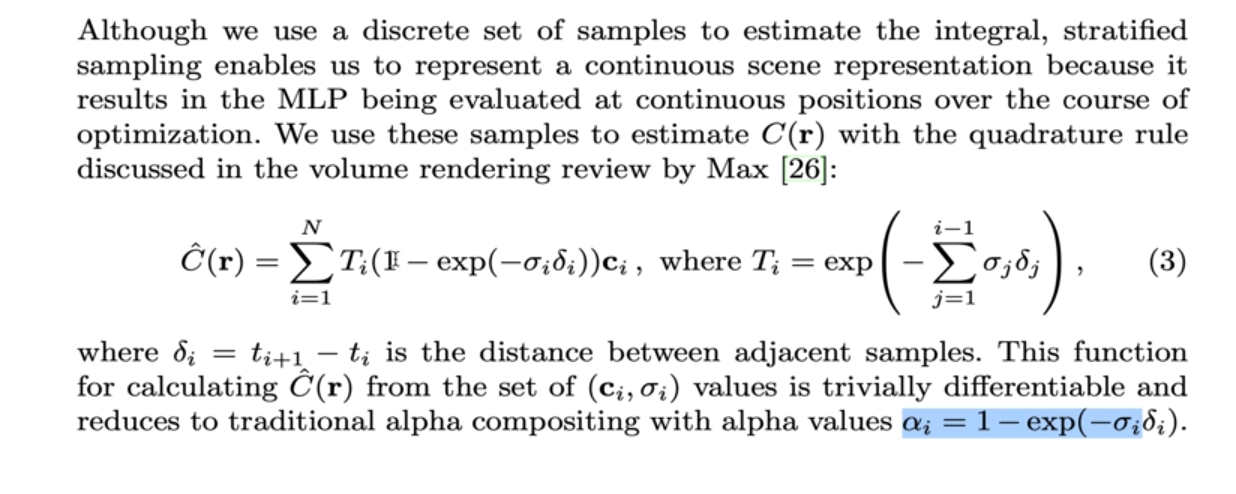

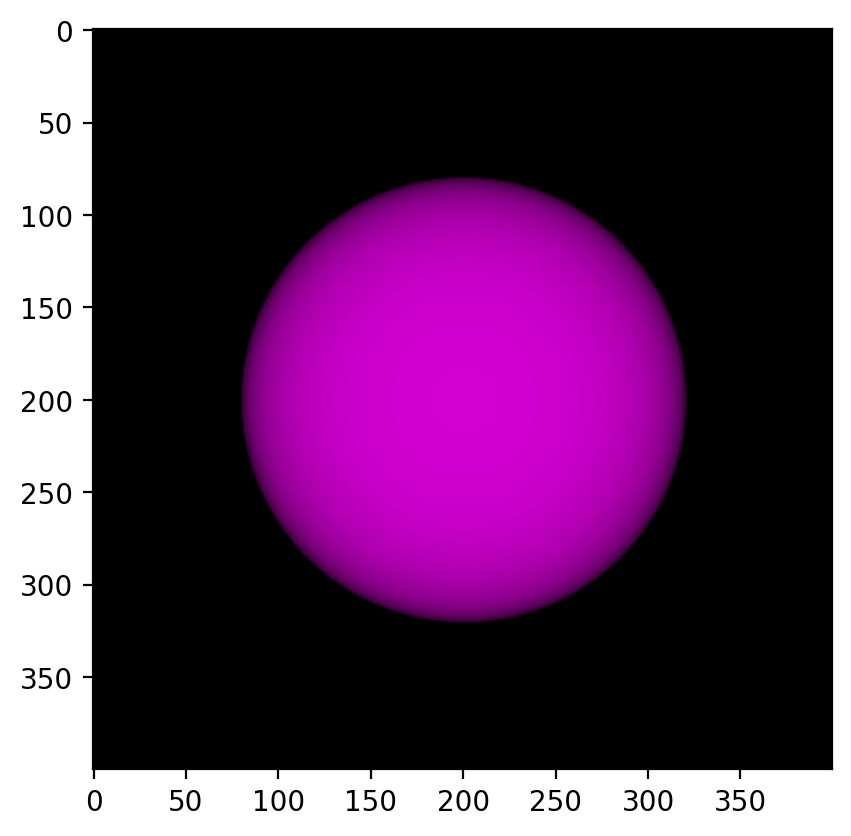

In [42]:
img = px_colors.reshape(H,W, 3).cpu().numpy()
plt.figure(dpi=200)
plt.imshow(img)